In [1]:
import json
import numpy as np
import pandas as pd
import os

from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18

In [2]:
with open("../qmof.json") as file:
    qmof_data = json.load(file)
    qmof_df = pd.json_normalize(qmof_data).set_index("qmof_id")


In [3]:
# qmof_id to name
qmof_id = "qmof-8a95c27"
s = qmof_df[qmof_df.index == qmof_id]["name"].item()
s

'ABACUF01_FSR'

In [15]:
# name to qmof_id
s = "DAGDEV_FSR"
qmof_id = qmof_df[qmof_df["name"] == s].index.item()
qmof_id

'qmof-0a35e41'

In [16]:
qmof_df.loc[qmof_df.index == qmof_id, "dos_in_bandgap"] = 0

In [17]:
bandgap = qmof_df[qmof_df["name"]==s]["outputs.pbe.bandgap"].item()
vbm = qmof_df[qmof_df["name"]==s]["outputs.pbe.vbm"].item()
cbm = qmof_df[qmof_df["name"]==s]["outputs.pbe.cbm"].item()

In [18]:
print(bandgap)
print(vbm)
print(cbm)
print(cbm-vbm)

1.6668740000000002
1.834665
3.501539
1.6668740000000002


In [19]:
dos_path = os.path.join("../files/EIDyjluDQ3eZnt-gI7Fc4Q/vasp_files/", s, "DOSCAR")

In [20]:
with open(dos_path) as file:
    lines = file.readlines()
    nions = int(lines[0].split()[1])
    e_info = [float(i) for i in lines[5].split()]
    e_min, e_max, nedos, efermi = e_info[0], e_info[1], int(e_info[2]), e_info[3]

    dos_data = np.array([[float(x) for x in l.split()] for l in lines[6:6+nedos]])

    atom_line_idx = np.array([7+ion_idx+(ion_idx+1)*nedos for ion_idx in range(nions)])
    atom_dos_data = np.array([[[float(x) for x in l.split()] for l in lines[idx:idx+nedos]] for idx in atom_line_idx])

In [40]:
dos_data.shape

(301, 5)

In [21]:
dos_data_bg = dos_data[(dos_data[:,0] > efermi) & (dos_data[:,0] < efermi+bandgap)]
dos_data_bg.shape

(8, 5)

In [22]:
np.sum(dos_data_bg, axis=0)

array([  22.367,    0.   ,    3.909, 1104.   ,  984.8  ])

In [23]:
efermi

1.94669122

In [24]:
efermi+bandgap

3.61356522

In [25]:
dos_data[(dos_data[:,0] > efermi) & (dos_data[:,0] < efermi+bandgap)]

array([[  2.053,   0.   ,   0.   , 138.   , 123.   ],
       [  2.265,   0.   ,   0.   , 138.   , 123.   ],
       [  2.477,   0.   ,   0.   , 138.   , 123.   ],
       [  2.69 ,   0.   ,   0.   , 138.   , 123.   ],
       [  2.902,   0.   ,   0.   , 138.   , 123.   ],
       [  3.114,   0.   ,   0.   , 138.   , 123.   ],
       [  3.327,   0.   ,   0.   , 138.   , 123.   ],
       [  3.539,   0.   ,   3.909, 138.   , 123.8  ]])

In [26]:
dos_data_bg[-1]

array([  3.539,   0.   ,   3.909, 138.   , 123.8  ])

In [27]:
dos_data_bg

array([[  2.053,   0.   ,   0.   , 138.   , 123.   ],
       [  2.265,   0.   ,   0.   , 138.   , 123.   ],
       [  2.477,   0.   ,   0.   , 138.   , 123.   ],
       [  2.69 ,   0.   ,   0.   , 138.   , 123.   ],
       [  2.902,   0.   ,   0.   , 138.   , 123.   ],
       [  3.114,   0.   ,   0.   , 138.   , 123.   ],
       [  3.327,   0.   ,   0.   , 138.   , 123.   ],
       [  3.539,   0.   ,   3.909, 138.   , 123.8  ]])

In [28]:
atom_dos_bg = atom_dos_data[(atom_dos_data[:,:,0] > efermi) & (atom_dos_data[:,:,0] < efermi+bandgap)]
atom_dos_bg = atom_dos_bg.reshape(
    atom_dos_data.shape[0],
    dos_data_bg.shape[0],
    atom_dos_data.shape[2]
)

In [29]:
atom_dos_bg.shape

(75, 8, 19)

In [58]:
up = np.array([1,3,5,7,9,11,13,15,17])
down = np.array([2,4,6,8,10,12,14,16,18])

In [62]:
atom_dos_bg[:,:,up].shape

(39, 5, 9)

In [64]:
np.sum(np.sum(atom_dos_bg[:,:,up], axis=2), axis=1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [50]:
atom_bg_sum = np.sum(atom_dos_bg, axis=2) - atom_dos_bg[:,:,0]

In [56]:
atom_bg_sum.shape

(39, 5)

In [52]:
np.sum(dos_data_bg, axis=0)[1]

0.0

In [53]:
np.sum(atom_bg_sum, axis=1)/np.sum(dos_data_bg, axis=0)[1]

/var/folders/gt/tsyp2wjd1ng0pkr1tf52kn600000gn/T/ipykernel_99143/779128951.py:1: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(atom_bg_sum, axis=1)/np.sum(dos_data_bg, axis=0)[1]


array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])

In [54]:
energies = dos_data[:,0]

In [23]:
atom_dos_sum = np.sum(atom_dos_data, axis=2) - atom_dos_data[:,:,0]

In [24]:
useful_data = np.array([atom_dos_sum[id, :][(energies>efermi) & (energies<efermi+bandgap)] for id in range(atom_dos_sum.shape[0])])

In [25]:
useful_data.shape

(104, 22)

In [26]:
bandgap_data = dos_data[(dos_data[:,0] > efermi) & (dos_data[:,0]<efermi+bandgap+0.2)]#[:-1]
#bandgap_data = bandgap_data[:-1]

In [27]:
bandgap_data

array([[  0.935,   0.   , 488.   ],
       [  1.055,   0.   , 488.   ],
       [  1.175,   0.   , 488.   ],
       [  1.295,   0.   , 488.   ],
       [  1.415,   0.   , 488.   ],
       [  1.536,   0.   , 488.   ],
       [  1.656,   0.   , 488.   ],
       [  1.776,   0.   , 488.   ],
       [  1.896,   0.   , 488.   ],
       [  2.016,   0.   , 488.   ],
       [  2.137,   0.   , 488.   ],
       [  2.257,   0.   , 488.   ],
       [  2.377,   0.   , 488.   ],
       [  2.497,   0.   , 488.   ],
       [  2.617,   0.   , 488.   ],
       [  2.737,   0.   , 488.   ],
       [  2.858,   0.   , 488.   ],
       [  2.978,   0.   , 488.   ],
       [  3.098,   0.   , 488.   ],
       [  3.218,   0.   , 488.   ],
       [  3.338,   0.   , 488.   ],
       [  3.458,   8.279, 489.   ],
       [  3.579,  35.66 , 493.3  ],
       [  3.699,  44.4  , 503.3  ]])

In [127]:
8.279/35.66

0.23216489063376333

In [119]:
bandgap_data[-1, 1] == 0

False

In [120]:
peak_in_bandgap_atom = []
for atom in range(atom_dos_data.shape[0]):
    peak_in_bandgap_atom.append(atom_dos_sum[atom,:][(dos_data[:,0] > efermi) & (dos_data[:,0]<efermi+bandgap)])

peak_in_bandgap_atom = np.array(peak_in_bandgap_atom)

In [121]:
peak_in_bandgap_atom

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0123759 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01238478],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01236781],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01572286],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01579726],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01577266]])

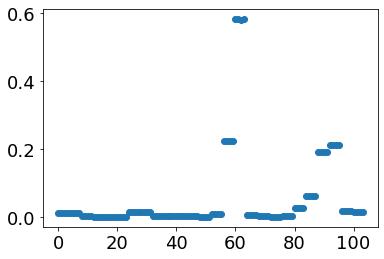

In [122]:
plt.scatter(range(atom_dos_data.shape[0]), np.sum(peak_in_bandgap_atom, axis=1))

In [123]:
np.max(dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)])

54.04

Text(0.5, 1.0, 'qmof-b57edb0')

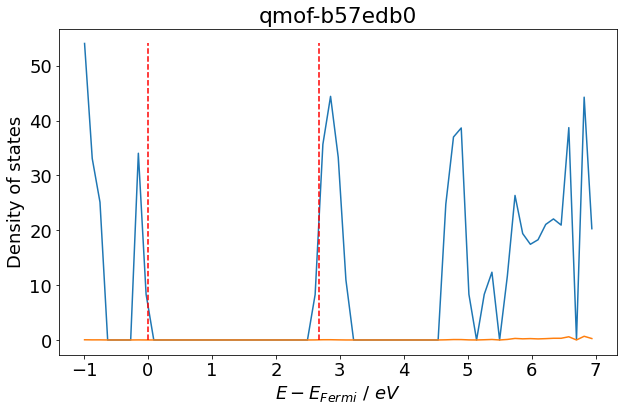

In [124]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(
    energies[(energies>efermi-1) & (energies<efermi+7)]-efermi,
    dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)], 
    #gaussian_filter1d(dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)], sigma=bandgap)
)
ax.plot(
    energies[(energies>efermi-1) & (energies<efermi+7)]-efermi, 
    atom_dos_sum[0,:][(energies>efermi-1) & (energies<efermi+7)]  
)
ax.plot([0,0], [0,np.max(dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)])], 'r--')
ax.plot([bandgap, bandgap], [0,np.max(dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)])], 'r--')
ax.set_xlabel("$E-E_{Fermi}\ /\ eV$")
ax.set_ylabel("Density of states")
ax.set_title("%s" %qmof_id)

# read qmofs with peaks in the bandgap

In [130]:
with open("../files/mofs_with_peaks") as f:
    mofs_peak = [l.split() for l in f.readlines()]

In [131]:
len(mofs_peak)

4357

In [133]:
qmof_id_peak = [qmof_df[qmof_df["name"] == q[0]].index.item() for q in mofs_peak]

In [134]:
len(qmof_id_peak)

4357

In [135]:
if "qmof-8a95c27" not in qmof_id_peak:
    print("yes")

yes


In [17]:
import shutil

In [20]:
for x in qmof_id_peak:
    src = os.path.join("/run/user/1001/gvfs/smb-share:server=lsmosrv2.epfl.ch,share=xiazhang/dos_plots", x+".png")
    dst = os.path.join("/run/user/1001/gvfs/smb-share:server=lsmosrv2.epfl.ch,share=xiazhang/dos_plots_peaks", x+".png")
    shutil.copyfile(src, dst)